# 手撕简易版Transformer

## 1. 模型图

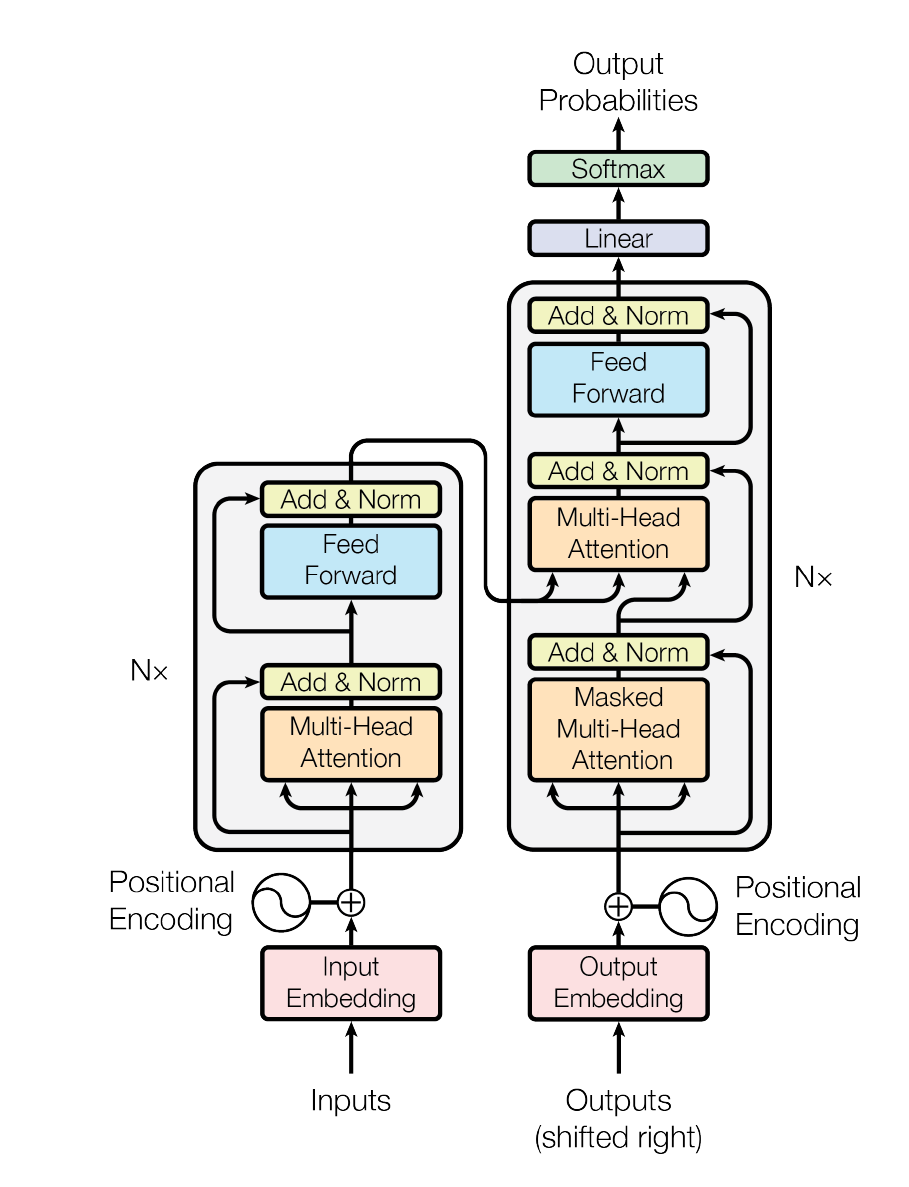

## 2. 模块划分

在编码先来看transformer的模型结构，我们先对其进行一个模块的划分以便能够更好的进行编程，划分图如下。

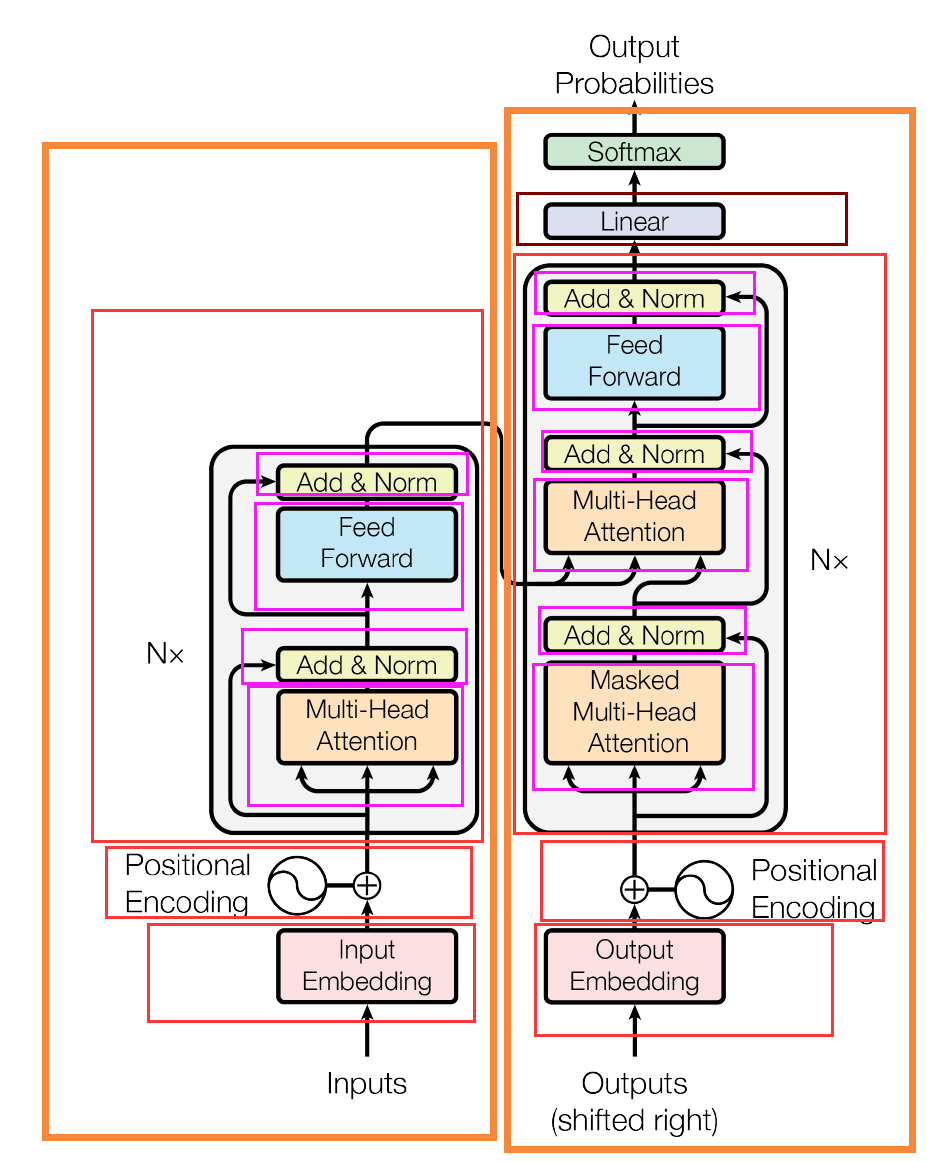

把他转换成思维导图的形式则是如下

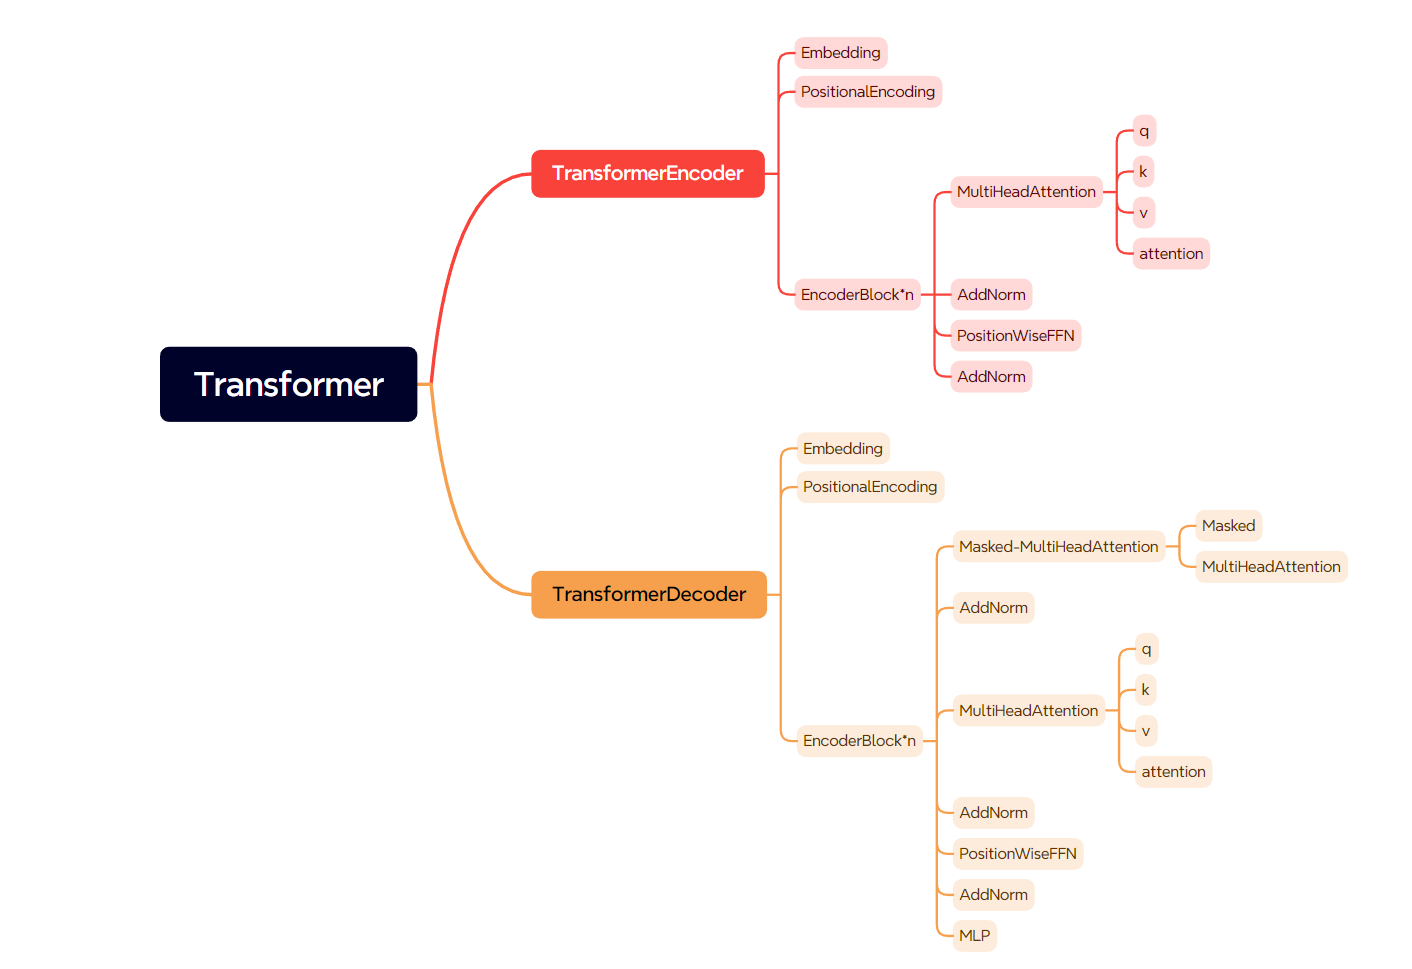

## 3. 编写程序 Transformer类的实现

模块划分完成了那么我就可以开始编码了，首先第一步就是导包，然后就是Transformer类的实现，环境配置请参考这个[链接](https://zh-v2.d2l.ai/chapter_installation/index.html)

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

Transformer类由编码器和解码器两部分组成，因此对于初始化方法来说只需要提供一个encoder和一个decoder即可。
对应forword我们需要提供源语言序列、目标语言序列以及学习率、epoch、batch_size等等一些列超参数，为了使用简单和提供可拓展性使用*args来接受这些超参数

In [2]:
# 构建Transformer类
class Transformer(nn.Module):
    # 初始化
    def __init__(self, encoder, decoder):
        # 调用nn.Module的初始化
        super().__init__()
        # 初始化encoder模块
        self.encoder = encoder
        # 初始化decoder模块
        self.decoder = decoder

    # 要使用模型，我们需要将输入数据传递给它。模型会自动运行forward方法
    # enc_X：编码器输入，即源语言序列
    # dec_X：解码器输入，即目标语言序列
    def forward(self, enc_X, dec_X, valid_lens):
        # 得到解码器的输出
        enc_outputs = self.encoder(enc_X, valid_lens)
        # 将编码器输入传入解码器中来构建编码器的状态例如是训练态还是预测态
        dec_state = self.decoder.init_state(enc_outputs, valid_lens)
        # 最后将dec_state与dec_X作为输入给解码器并返回
        return self.decoder(dec_X, dec_state)

### 3.1 TransformerEncoder类的实现

接下来我们先来实现TransformerEncoder类。  
TransformerEncoder由embedding、PositionalEncoding以及EncoderBlock组成。  
首先是init方法，按照惯例我们继续去分析他的输入和输出。  
首先作为一个编码我需要确定我的源语言库当中总共有多少的词汇量以便最后能够成功映射因此我们需要一个vocab_size参数。  
然后一系列的超参数了，例如Transformer是基于attention的因此必然需要qkv这三个向量的维度信息，因此需要key_size, query_size, value_size这三个参数其余的超参数我就列举在这不一一解释了。  
num_hiddens: 隐藏层的维度。  
norm_shape: 应用层归一化的维度。  
ffn_num_input, ffn_num_hiddens: 前馈网络（FeedforwardNetwork, FFN）的输入和隐藏层维度。  
num_heads: 注意力机制的头数。  
num_layers: 编码器层数。  
dropout: 在训练时丢弃的比例。  
use_bias: 是否在注意力机制和前馈网络中使用偏置项

然后是forword方法，其实就是对这三个模块embedding、PositionalEncoding以及EncoderBlock进行一个堆叠，值得注意的是位置编码值在-1和1之间，embedding的维度越大值越小，为了使pos_encoding和embedding差不多大故让embedding乘一个根号维度

In [3]:
# 构建TransformerEncoder类
class TransformerEncoder(nn.Module):
    # vocab_size: 输入词汇的大小。
    # key_size, query_size, value_size: 分别用于设置键、查询和值的维度，这些是注意力机制中的参数。
    # num_hiddens: 隐藏层的维度。
    # norm_shape: 应用层归一化的维度。
    # ffn_num_input, ffn_num_hiddens: 前馈网络（FeedforwardNetwork, FFN）的输入和隐藏层维度。
    # num_heads: 注意力机制的头数。
    # num_layers: 编码器层数。
    # dropout: 在训练时丢弃的比例。
    # use_bias: 是否在注意力机制和前馈网络中使用偏置项。
    def __init__(self, vocab_size, query_size, key_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False):
        # 调用父类 nn.Module 的构造函数，初始化父类
        super().__init__()
        # 记录向量的维度后续用于缩放向量大小
        self.num_hiddens = num_hiddens
        # embbeding层
        self.embbeding = nn.Embedding(vocab_size, num_hiddens)
        # position_embedding层
        self.pos_embbedding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 初始化了一个空的 nn.Sequential 容器，用于顺序存放n个EncoderBlock。
        self.blks = nn.Sequential()

        # 将n个EncoderBlock存放入Sequential中
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 EncoderBlock(query_size, key_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, use_bias))

    # 定义了前向传播函数，接收输入 X 和有效长度 valid_lens。
    def forward(self, X, valid_lens):
        # 先经过embbeing层
        X = self.embbeding(X)
        # 因为位置编码值在-1和1之间，embedding的维度越大值越小，为了使pos_encoding和embedding差不多大故让embedding乘一个根号维度
        X = X * math.sqrt(self.num_hiddens)
        # 再经过position_embedding层
        X = self.pos_embbedding(X)

        # 最后经过n个EncoderBlock
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
        # 返回结果
        return X

#### 3.1.1 EncoderBlock类的实现

接下来我们来实现TransformerEncoder类中最为关键的EncoderBlock类。  
首先是init方法，EncoderBlock相较于TransformerEncoder并不需要经过embbedding故并不需要传入vocab_size参数并且EncoderBlock是单层的故不需要num_layers这个参数其余传参都一样  
EncoderBlock是由MultiHeadAttention、AddNorm、PositionWiseFFN、AddNorm构成故需要对其进行初始化

然后是forword方法就是对MultiHeadAttention、AddNorm、PositionWiseFFN、AddNorm进行一个简单的堆叠

In [4]:
# 构建EncoderBlock类
class EncoderBlock(nn.Module):
    # key_size, query_size, value_size: 分别用于设置键、查询和值的维度，这些是注意力机制中的参数。
    # num_hiddens: 隐藏层的维度。
    # norm_shape: 应用层归一化的维度。
    # ffn_num_input, ffn_num_hiddens: 前馈网络（FeedforwardNetwork, FFN）的输入和隐藏层维度。
    # num_heads: 注意力机制的头数。
    # dropout: 在训练时丢弃的比例。
    # use_bias: 是否在注意力机制和前馈网络中使用偏置项。
    def __init__(self, query_size, key_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, dropout, use_bias=False):
        # 调用父类 nn.Module 的构造函数，初始化父类
        super().__init__()
        # 初始化多头自注意力机制 (Multi-Head Attention)
        # 使用指定的键、查询和值的尺寸，隐藏层的大小，多头数量，dropout 概率，以及是否使用偏置项
        self.multi_head_attention = MultiHeadAttention(query_size, key_size, value_size, num_hiddens, num_heads,
                                                       dropout, use_bias)
        # 初始化第一个 AddNorm 层
        # 包括残差连接和层规范化，使用给定的规范化形状和 dropout 概率
        self.add_norm1 = AddNorm(norm_shape, dropout)
        # 初始化基于位置的前馈网络
        # 输入维度是 ffn_num_input，隐藏层维度是 ffn_num_hiddens，输出维度是 num_hiddens
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        # 初始化第二个 AddNorm 层
        self.add_norm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        # 通过多头自注意力机制
        Y = self.multi_head_attention(X, X, X, valid_lens)
        # 然后通过第一个 AddNorm 层（包括残差连接和 LayerNorm）
        Y = self.add_norm1(X, Y)
        # 通过前馈神经网络 (FFN)，然后通过第二个 AddNorm 层
        Y = self.add_norm2(Y, self.ffn(Y))
        # 返回结果
        return Y

#### 3.1.2 多头自注意力机制MultiHeadAttention的实现

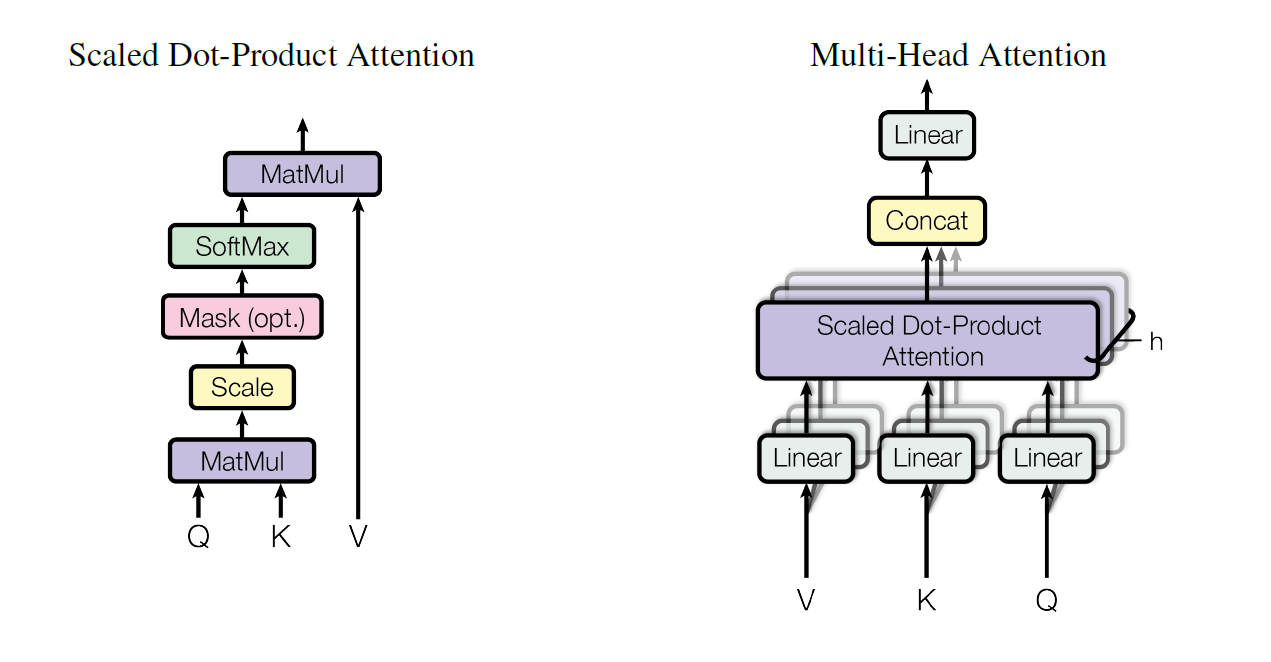

由上图可知，多头自注意力机制其实就是将QKV经过一个**线性层**然后再经过一个**缩放点积注意力**，最后将多个头的结果合并成一个  
首先考虑init方法，入参为显然需要qkv的大小，既然要经过线性变换那必然要有num_hiddens，“多头”则需要num_heads，最后就是dropout和bias了
要做的任务就是初始化qkv的线性层并初始化最后输出的线性层

然后考虑forword方法只需要qkv和一个有效长度valid_lens，做法还是搭积木，先经过线性层然后再经过DotProductAttention最后将结果进行一个合并，最后再经过一个线性层

In [5]:
# 构建MultiHeadAttention类
class MultiHeadAttention(nn.Module):
    # key_size, query_size, value_size: 分别用于设置键、查询和值的维度，这些是注意力机制中的参数。
    # num_hiddens: 隐藏层的维度。
    # num_heads: 注意力机制的头数。
    # dropout: 在训练时丢弃的比例。
    # use_bias: 是否在注意力机制和前馈网络中使用偏置项。
    def __init__(self, query_size, key_size, value_size, num_hiddens, num_heads, dropout, bias=False):
        # 调用父类 nn.Module 的构造函数，初始化父类
        super().__init__()
        # 记录头数，forward对qkv进行拆分与合并时要用到
        self.num_heads = num_heads
        # 初始化缩放点积注意力
        self.attention = DotProductAttention(dropout)
        # 初始化q的全连接层
        self.w_q = nn.Linear(query_size, num_hiddens, bias)
        # 初始化k的全连接层
        self.w_k = nn.Linear(key_size, num_hiddens, bias)
        # 初始化v的全连接层
        self.w_v = nn.Linear(value_size, num_hiddens, bias)
        # 初始化o的全连接层
        self.w_o = nn.Linear(num_hiddens, num_hiddens, bias)

    # 为了提供并行能力往往不采用for循环的方式来切割与合并qkv而是采用张量运算的方式一次性完成
    # 步骤：1.将qkv经过全连接层  2.将qkv切割成多头  3.经过attention  4.合并结果  5.将结果经过全连接层
    def forward(self, queries, keys, values, valid_lens):
        # 1.将qkv经过全连接层
        # queries，keys，values的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
        queries = self.w_q(queries)
        keys = self.w_k(keys)
        values = self.w_v(values)

        # 2.将qkv切割成多头
        # 经过变换后，输出的queries，keys，values　的形状:(batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(queries, self.num_heads)
        keys = transpose_qkv(keys, self.num_heads)
        values = transpose_qkv(values, self.num_heads)

        # valid_lens主要是实现masked机制，为了不看到未来的内容
        # 由于每个注意力头都独立处理输入序列，故需要复制num_heads份
        if valid_lens is not None:
            # 将valid_lens复制num_heads份
            # valid_lens　的形状:(batch_size，)或(batch_size，查询的个数)
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        # 3.经过attention
        # output的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # 4.合并结果
        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)

        # 5.将结果经过全连接层并返回
        return self.w_o(output_concat)

之所以要这么复杂的经过transpose_qkv和transpose_output主要是为了提升计算速度，其中transpose_qkv的作用就是将张量切割成多个头，transpose_output就是将多个头的张量合并成一个，代码如下所示

In [6]:
# 将不同的注意力头分开处理。
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,num_hiddens/num_heads)
    # permute 方法用于重新排列一个张量的维度。
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


# 目的是将不同头的输出合并
def transpose_output(X, num_heads):
    """逆转 transpose_qkv 函数的操作，将不同头的输出合并"""

    # 先将 X 的形状从 (batch_size*num_heads, 查询或“键－值”对的个数, num_hiddens/num_heads)
    # 转换为 (batch_size, num_heads, 查询或“键－值”对的个数, num_hiddens/num_heads)
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])

    # 使用 permute 方法重新排列张量的维度
    # 将 X 的形状从 (batch_size, num_heads, 查询或“键－值”对的个数, num_hiddens/num_heads)
    # 转换为 (batch_size, 查询或“键－值”对的个数, num_heads, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最后将 X 的形状变换为 (batch_size, 查询或“键－值”对的个数, num_hiddens)
    # 这一步将不同注意力头的输出合并
    return X.reshape(X.shape[0], X.shape[1], -1)

这个矩阵的变换过程比较复杂，可以参考下图
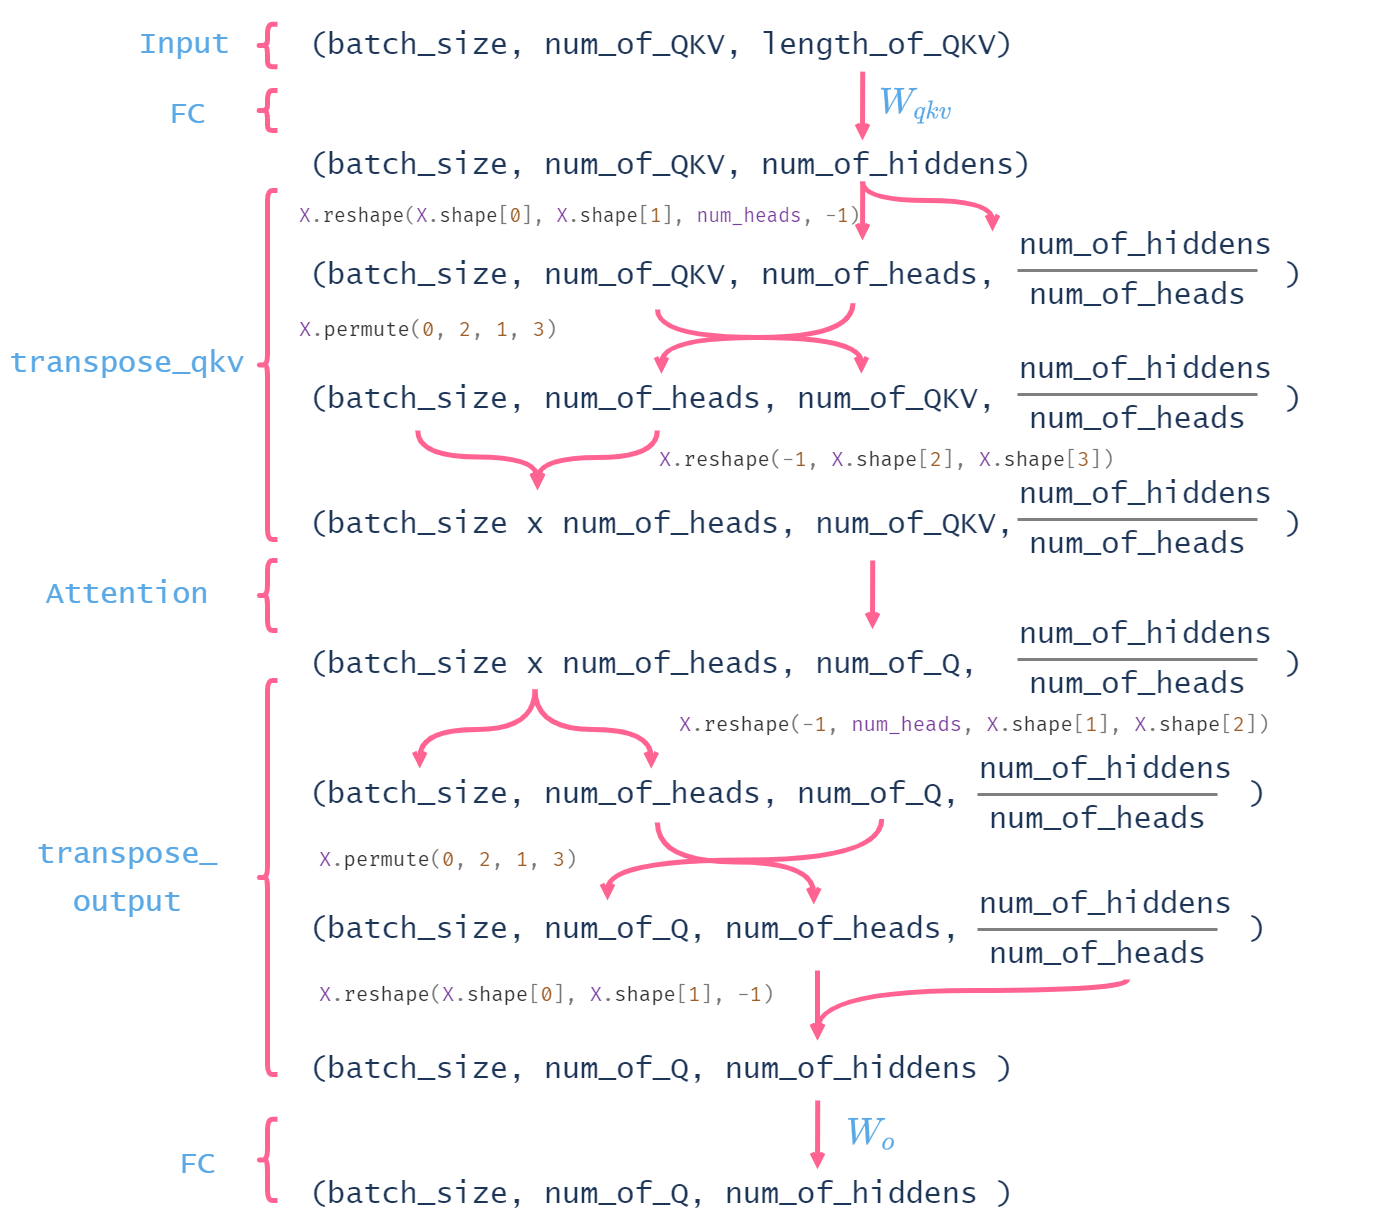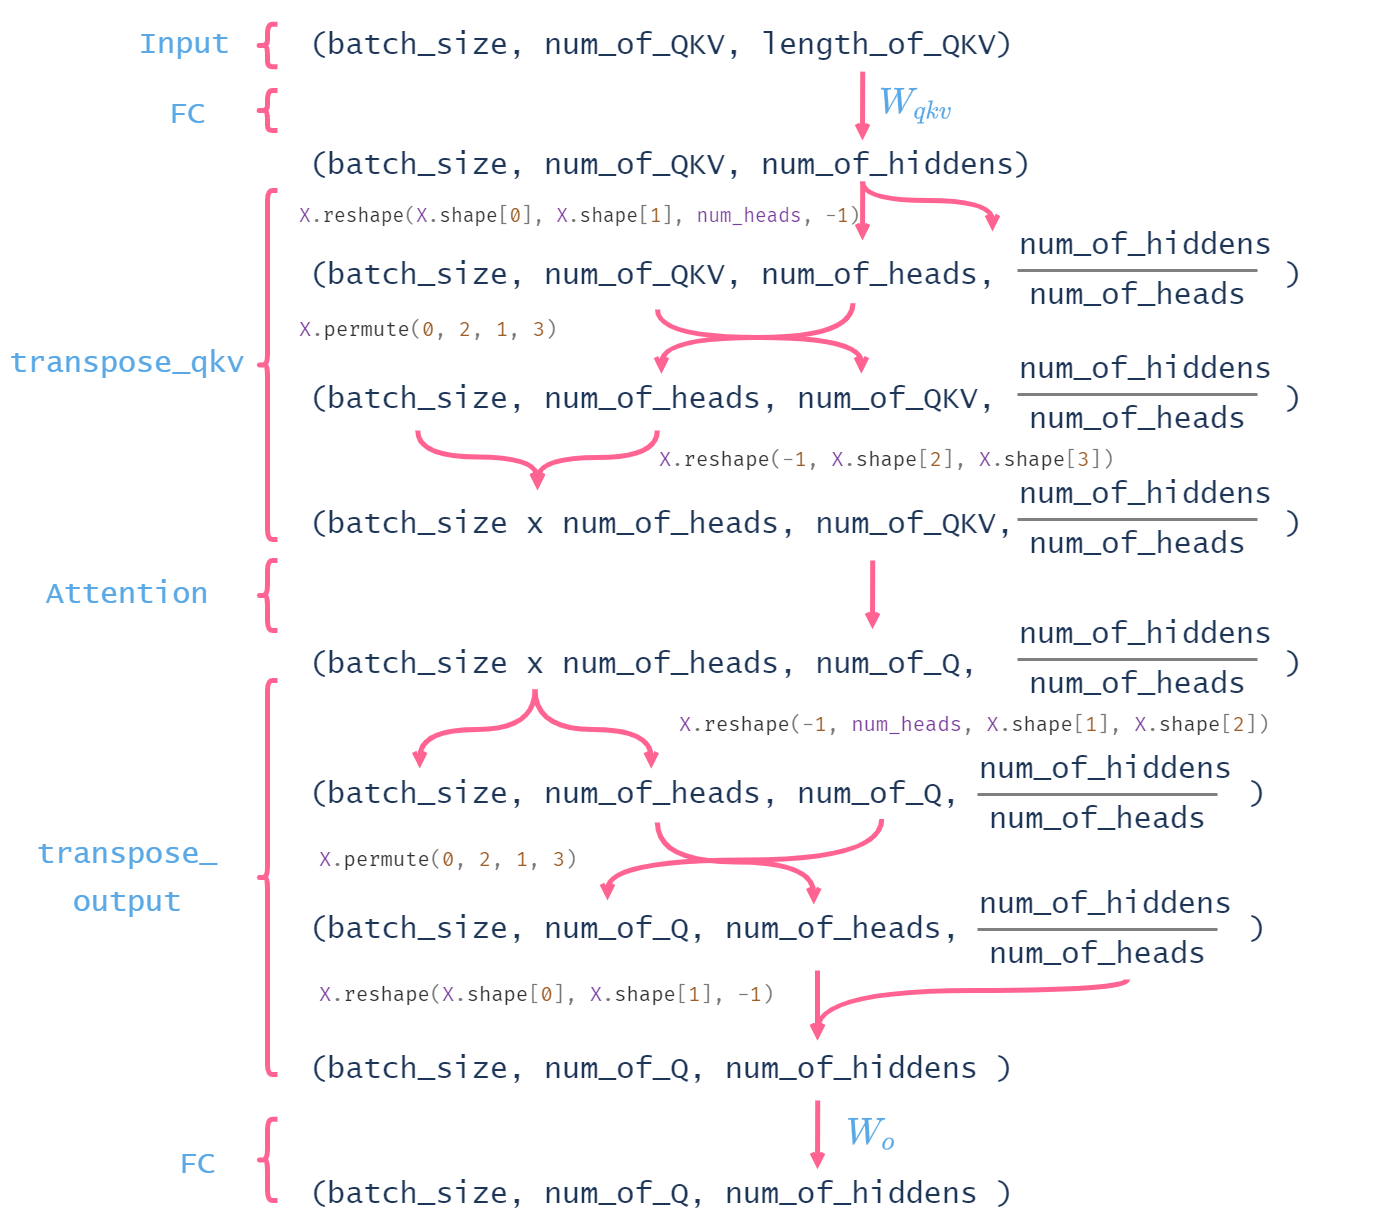

#### 3.1.3 DotProductAttention类的实现

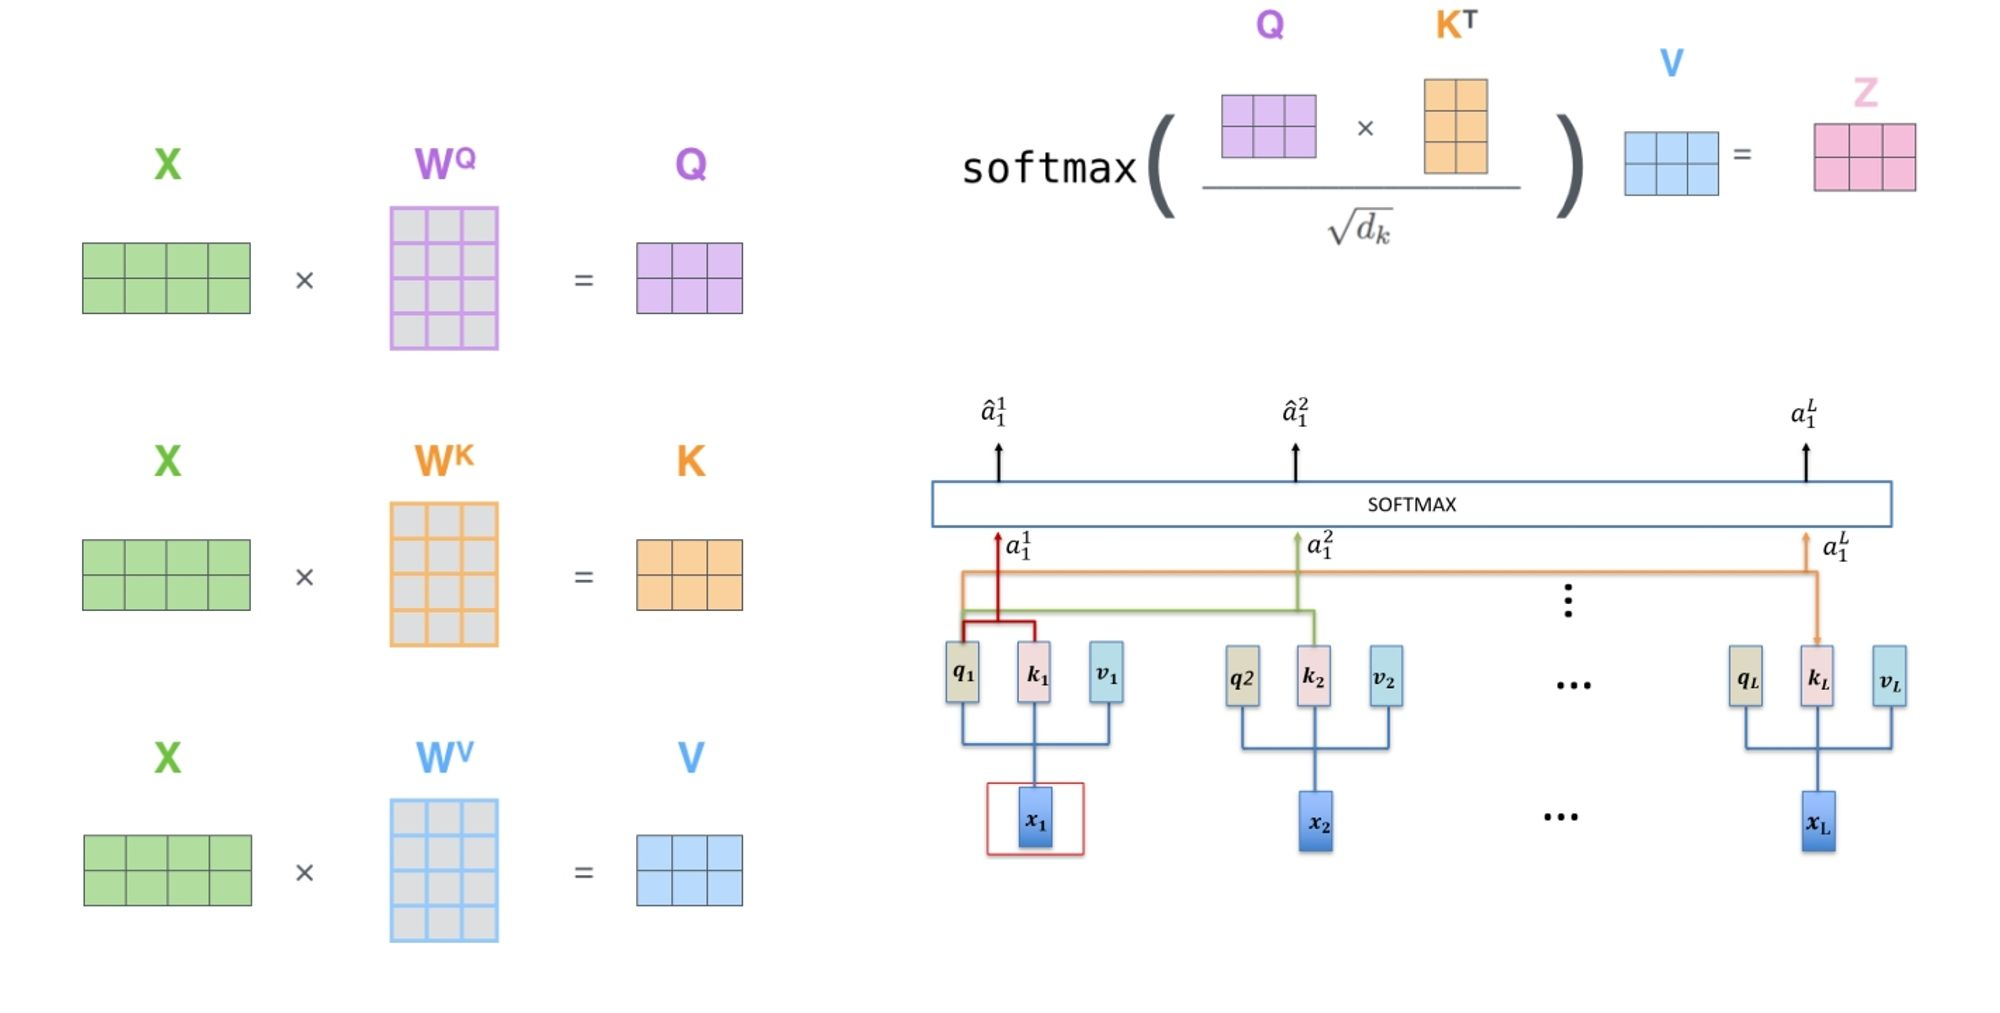

DotProductAttention就是一个非常简单的矩阵运算，Q乘以K转置除以根号dk然后经过一个softmax最后乘上一个V就是要的结果

In [7]:
# 构建DotProductAttention类
class DotProductAttention(nn.Module):
    # dropout：dropout的比例
    def __init__(self, dropout):
        super().__init__()
        # 在初始化函数中，我们首先调用基类的初始化方法。然后创建一个 nn.Dropout 层，用于在注意力权重上应用dropout，以减少过拟合。
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        # 拿到维度d
        d = queries.shape[-1]
        # torch.bmm 是批量矩阵乘法，用于计算批次中每个样本的分数（scores）。
        # 在PyTorch中，transpose(1, 2) 方法用于交换张量的两个指定维度。
        # 对于 keys.transpose(1, 2)，这意味着交换 keys 张量的第二个维度（索引为 1）和第三个维度（索引为 2）。
        # 具体来说，如果 keys 的形状是 (batch_size, num_keys, d)，则 keys.transpose(1, 2) 会改变其形状为 (batch_size, d, num_keys)。
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        # 将结果经过一个softmax得到attention_weights
        self.attention_weights = d2l.masked_softmax(scores, valid_lens)
        # 最后将权重与values相乘
        return torch.bmm(self.dropout(self.attention_weights), values)

#### 3.1.4 残差连接和层规范化层 AddNorm

这个类的实现就比较简单了就是进行一个残差和一个LayerNorm规范化

In [8]:
# 构建AddNorm类
class AddNorm(nn.Module):
    """残差连接后进行层规范化 (Layer Normalization after Residual Connection)"""

    # normalized_shape: 指定需要归一化的特征维度。
    # dropout：dropout的比例
    def __init__(self, normalized_shape, dropout):
        # 调用父类 nn.Module 的构造函数，初始化父类
        super().__init__()
        # 初始化 Dropout 层，用于防止过拟合
        self.dropout = nn.Dropout(dropout)
        # 初始化 LayerNorm 层，用于对输入进行层规范化，normalized_shape 指定了要规范化的维度
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        # 先对 Y 应用 Dropout，然后将结果与输入 X 相加 (实现残差连接)
        # 再对相加的结果应用 LayerNorm，并返回最终输出
        return self.ln(self.dropout(Y) + X)

#### 3.1.5 基于位置的前馈网络 PositionWiseFFN

FFN本质上就是一个MLP，两个全连接层中间夹个激活函数

In [9]:
# 前面的Attention将输入的信息提取出来（语义，位置，序列等）然后将这些信息通过FFN其中两层感知机中，第一层会将输入的向量升维，然后经过一个激活函数提升泛化能力，第二层将向量重新降维。这样子就可以学习到更加抽象的特征。
# 如果只有线性变换那么结果依然是线性的，所以需要引入非线性变换
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络 (Position-wise Feed-Forward Network)"""

    # ffn_num_input：输入层节点数
    # ffn_num_hiddens：隐藏层节点数
    # ffn_num_outputs：输出层节点数
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs):
        # 调用父类nn.Module的构造函数，初始化父类
        super().__init__()
        # 定义第一层全连接层，将输入维度从ffn_num_input变换到ffn_num_hiddens
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        # 定义激活函数为ReLU
        self.relu = nn.ReLU()
        # 定义第二层全连接层，将维度从ffn_num_hiddens变换到ffn_num_outputs
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        # 执行前向传播：首先通过第一层全连接层dense1，然后通过ReLU激活函数，
        # 最后通过第二层全连接层dense2并返回结果
        return self.dense2(self.relu(self.dense1(X)))

### 3.2 TransformerDecoder类的实现

TransformerDncoder与Encoder部分可以说是完全相同仅仅增加了一个MaskedMultiHeadAttention机制  
增加一个Masked是为了在预测时屏蔽未来的token减少干扰，这里我们采用state的方式来记录状态  
以及增加了一层Linear  
直接来看代码吧

In [10]:
class TransformerDecoder(nn.Module):
    # vocab_size: 输入词汇的大小。
    # key_size, query_size, value_size: 分别用于设置键、查询和值的维度，这些是注意力机制中的参数。
    # num_hiddens: 隐藏层的维度。
    # norm_shape: 应用层归一化的维度。
    # ffn_num_input, ffn_num_hiddens: 前馈网络（FeedforwardNetwork, FFN）的输入和隐藏层维度。
    # num_heads: 注意力机制的头数。
    # num_layers: 编码器层数。
    # dropout: 在训练时丢弃的比例。
    # use_bias: 是否在注意力机制和前馈网络中使用偏置项。
    def __init__(self, vocab_size, query_size, key_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False):
        # 调用父类 nn.Module 的构造函数，初始化父类
        super().__init__()
        # 记录解码器层数下面init_state要用。
        self.num_layers = num_layers
        # 记录向量的维度后续用于缩放向量大小
        self.num_hiddens = num_hiddens
        # embbeding层
        self.embbeding = nn.Embedding(vocab_size, num_hiddens)
        # position_embedding层
        self.pos_embbedding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 初始化了一个空的 nn.Sequential 容器，用于顺序存放n个EncoderBlock。
        self.blks = nn.Sequential()

        # 将n个EncoderBlock存放入Sequential中
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 DecoderBlock(query_size, key_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, i))
        # 初始化最后要经过的全连接层
        self.dense = nn.Linear(num_hiddens, vocab_size)

    # 初始化状态就是多生成一个列表用于存储之前的输出结果,主要用于判断是否是预测阶段和存储之前的输出结果
    def init_state(self, enc_outputs, enc_valid_lens):
        # 构建状态，其实就是往里面塞了一个长度为num_layers，值全为None的张量列表
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    # 定义了前向传播函数，接收输入 X 和有效长度 valid_lens。
    # X：输入到解码器的数据。
    # state：从 init_state 方法中得到的状态。
    def forward(self, X, state):
        # 先经过embbeing层
        X = self.embbeding(X)
        # 因为位置编码值在-1和1之间，embedding的维度越大值越小，为了使pos_encoding和embedding差不多大故让embedding乘一个根号维度
        X = X * math.sqrt(self.num_hiddens)
        # 再经过position_embedding层
        X = self.pos_embbedding(X)

        # 最后经过n个EncoderBlock
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
        # 返回预测值和state
        return self.dense(X), state


#### 3.2.1 DecoderBlock类的实现

实现也是与EncoderBlock类似，但值得注意的是训练状态和预测状态的Decode是不一样的，故我们采用了一个state来记录，如果state是空的话说明训练的一个状态，我们就将输入一性传入X，然后要mask掉未来的内容，而mask则是使用valid_lens来实现。如果是预测状态则需要一个一个传入，既然是一个一个输入就不需要valid_lens

In [11]:
# 构建DecoderBlock类
class DecoderBlock(nn.Module):
    """解码器中第i个块"""

    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i):
        super().__init__()
        # 记录第i个块
        self.i = i
        # 初始化Masked-MultiHeadAttention
        self.masked_multi_head_attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens,
                                                              num_heads, dropout)
        # 初始化第一个AddNorm层
        self.add_norm1 = AddNorm(norm_shape, dropout)
        self.multi_head_attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads,
                                                       dropout)
        # 初始化第二个AddNorm层
        self.add_norm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        # 初始化第三个AddNorm层
        self.add_norm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        # 初始化enc_outputs, enc_valid_lens
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            # 训练状态下，输入一次性传入
            key_values = X
        else:
            # 预测状态下，token是一个一个传入的故需要将之前的输出进行一个拼接
            key_values = torch.cat((state[2][self.i], X), axis=1)
        # 更新state
        state[2][self.i] = key_values
        # 训练态
        if self.training:
            # 初始化batch_size
            batch_size = X.shape[0]
            # 初始化num_steps
            num_steps = X.shape[1]
            # dec_valid_lens的开头:(batch_size,num_steps),其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        # 预测态时不需要valid_lens，因为是一个一个输入的
        else:
            dec_valid_lens = None
        # 经过一层masked_multi_head_attention，其中masked的任务由valid_lens实现
        # q是当前输入，kv则是之前的输出
        X2 = self.masked_multi_head_attention(X, key_values, key_values, dec_valid_lens)
        # 经过第一个AddNorm层
        Y = self.add_norm1(X, X2)
        # 经过multi_head_attention
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        # q是来自decoder，kv则是来自encoder
        Y2 = self.multi_head_attention(Y, enc_outputs, enc_outputs, enc_valid_lens)
        # 经过第二个AddNorm层
        Z = self.add_norm2(Y, Y2)
        # 经过第三个AddNorm层，并返回
        return self.add_norm3(Z, self.ffn(Z)), state


## 4. 训练模型

loss 0.031, 3368.8 tokens/sec on cpu


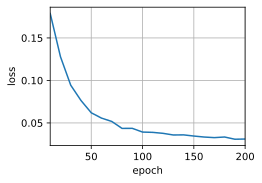

In [12]:
# num_hiddens: 隐藏层单元的数量。在深度学习模型中，这通常指的是模型中间层的宽度，即每层的神经元或隐藏单元的数量。嵌入的维度
# num_layers: 网络层数。在堆叠的神经网络架构中，这表示有多少个重复的层，例如在Transformer模型中的编码器和解码器层数。
# dropout: Dropout率。这是一种正则化技术，用于防止神经网络过拟合。在训练过程中，dropout会随机将网络中的一部分单元暂时从网络中丢弃，即把它们的输出设置为0。
# batch_size: 每个批次的样本数。在训练过程中，数据通常被分成小批量（batch），并且模型会在每个批次上进行更新。
# num_steps: 序列长度或时间步数。这通常表示输入和输出序列的最大长度。
# lr: 学习率。这是一个超参数，用于控制在优化过程中权重更新的步长大小。
# num_ds: 训练周期数。一个周期意味着整个训练数据集已经被模型看过一次。
# device: 训练设备。这通常指定了模型训练是在CPU上还是在GPU上进行。
# ffn_num_input: 前馈网络的输入维度。在Transformer模型中，前馈网络是模型内部的一个组件，用于在注意力机制后进一步处理数据。
# ffn_num_hiddens: 前馈网络的隐藏层单元数量。
# num_heads: 注意力机制中头的数量。在多头注意力（multi-head attention）中，注意力机制被分割成多个“头”，每个“头”学习输入数据的不同部分。
# key_size, query_size, value_size: 这些参数定义了在注意力机制中用于键（keys）、查询（queries）和值（values）的维度大小。在多头注意力中，输入序列被转换成这些维度以进行自注意力计算。
# norm_shape: 归一化层的形状。在Transformer模型中，通常会在多头注意力和前馈网络后使用层归一化（layer normalization）。
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

# 返回数据迭代器、源语言词汇表和目标语言词汇表。
# 这个函数的主要目的是加载和预处理神经机器翻译的数据集，并将其转换为可以用于训练和评估的形式。通过这个函数，你可以方便地获取数据迭代器和词汇表，以便在模型训练中使用。
# 截断：如果一个句子的长度超过 num_steps，它将被截断，这意味着超过 num_steps 长度的部分将不会被模型看到。
# 填充：如果一个句子的长度小于 num_steps，它将被填充（通常使用特定的填充符号，如 <pad>），以确保所有句子都具有统一的长度。这对于批处理操作至关重要，因为大多数深度学习框架要求批次中的数据具有相同的维度。
# num_steps 的选择可能会影响模型的性能。太短可能导致重要信息的丢失，而太长则可能导致训练不稳定或过拟合，特别是在数据中大多数句子都远小于 num_steps 设定值的情况下。
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), query_size, key_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), query_size, key_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)



net = Transformer(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 5. 预测模型检验效果

In [13]:
# 定义了两个列表：engs 包含英语句子，fras 包含对应的法语翻译。
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
# 使用 zip 函数将英语和法语句子配对，并在循环中逐对处理。
for eng, fra in zip(engs, fras):
    # 调用d2l.predict_seq2seq函数进行翻译。这个函数的参数包括：
    # net：已训练的序列到序列模型。
    # eng：当前的英语句子。
    # src_vocab：源语言（英语）的词汇表。
    # tgt_vocab：目标语言（法语）的词汇表。
    # num_steps：序列的最大长度。
    # device：用于预测的设备（如CPU或GPU）。
    # True：save_attention_weights。
    # 函数返回翻译后的句子和解码器的注意力权重序列。
    translation = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)[0]
    # 打印出原始的英语句子、翻译后的法语句子，以及使用 d2l.bleu 函数计算的BLEU分数。k=2 参数可能指的是BLEU评分中使用的n-gram的最大长度。
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000
